In [53]:
import sys
sys.path.append("..")

In [20]:
#!{sys.executable} -m pip install statsmodels --user
#!{sys.executable} -m pip install scipy --user

In [4]:
import blocksci
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy
import statsmodels
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import grangercausalitytests 
import warnings; warnings.simplefilter('ignore')
from scipy import signal

In [5]:
chain = blocksci.Blockchain("/home/ubuntu/bitcoin")

In [6]:
converter = blocksci.CurrencyConverter()

## Random Stuff/Testing

In [3]:
%time filtered_blocks = chain.map_blocks(lambda block: block.fee/1e9, start = "2017-1-1", end = "2017-12-30") 

CPU times: user 1.94 s, sys: 1.04 s, total: 2.98 s
Wall time: 21.3 s


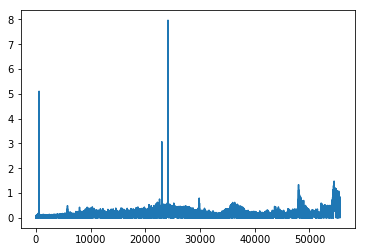

In [4]:
plt.plot(filtered_blocks)

In [9]:
chain.address_count(blocksci.address_type.pubkey)

440796846

In [27]:
%time filtered_blocks = chain.map_blocks(lambda block: block.input_count, start = "2013-1-1", end = "2017-12-30") 

Process ForkPoolWorker-2:
Process ForkPoolWorker-4:
Process ForkPoolWorker-1:
Process ForkPoolWorker-3:
Process ForkPoolWorker-6:
Process ForkPoolWorker-5:
Process ForkPoolWorker-7:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.5/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
  File "/home/ubuntu/.local/lib/python3.5/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.5/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
  File "/home/ubuntu/.local/lib/python3.5/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
  File "/home/ubuntu/.local/lib/python3.5/site-packages/multiprocess/process.py", line 93, in run
    self._target(*self._ar

KeyboardInterrupt: 

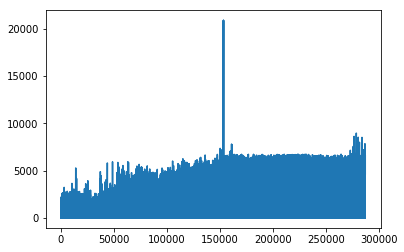

In [6]:
plt.plot(filtered_blocks)

## Average Transaction Size

In [55]:
print(len(chain))

541721


In [67]:
#Getting the average size of bitcoin transaction
%time tx_size = [(block.height, np.mean(block.txes.size_bytes)) for block in chain[0:400000]]

CPU times: user 1min 35s, sys: 2 s, total: 1min 37s
Wall time: 1min 59s


In [68]:
%time tx_size2 = [(block.height, np.mean(block.txes.size_bytes)) for block in chain[400000:510000]]

CPU times: user 2min 28s, sys: 5.19 s, total: 2min 34s
Wall time: 3min 44s


Text(0.5,1,'Average Monthly Transaction Size')

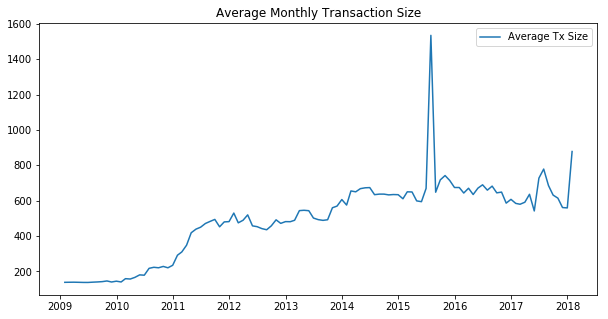

In [124]:
#concatenate lists
avg_tx_size = tx_size + tx_size2
df_avg_size = pd.DataFrame(avg_tx_size, columns=["Height", "Average Tx Size"])
df_avg_size = chain.heights_to_dates(df_avg_size)
#Take the monthly means of the average size of bitcoin transactions 
del df_avg_size["Height"]
df_avg_size = df_avg_size.resample("M").mean()
df_avg_size = df_avg_size[:-1]#drop last row.
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df_avg_size)
ax.legend(["Average Tx Size"])
ax.set_title("Average Monthly Transaction Size")

In [45]:
from2015_chain = chain.range('2015-07-07', '2015-07-08')
filtered_txes = [(block.txes, block.txes.size_bytes) for block in from2015_chain]

In [68]:
'''Analysing the spike in the graph.'''
largest_tx_size = 0
indexI, indexJ = 0, 0
for i in range(0, len(filtered_txes)):
    txes = filtered_txes[i]
    for j in range(0, len(txes[1])):
        if txes[1][j] > largest_tx_size:
            largest_tx_size = txes[1][j]
            indexI = i 
            indexJ = j 
            
largest_tx = filtered_txes[indexI][0].all[indexJ]

#display details about the largest transaction found. 
print("Largest Transaction Size:", largest_tx_size)
print("Largest Transaction:", largest_tx)
print("Largest Transaction Hash:", largest_tx.hash)
print("Height of this Transaction:", largest_tx.block_height)
print("Date received:", largest_tx.block_time)
print("Fee paid by this transaction:", largest_tx.fee)
print("Output value:", largest_tx.output_value)
print("Weight:", largest_tx.weight)

Largest Transaction Size: 999657
Largest Transaction: Tx(len(txins)=5569, len(txouts)=1, size_bytes=999657, block_height=364292, tx_index=74951012)
Largest Transaction Hash: bb41a757f405890fb0f5856228e23b715702d714d59bf2b1feb70d8b2b4e3e08
Height of this Transaction: 364292
Date received: 2015-07-07 18:19:07
Fee paid by this transaction: 0
Output value: 5569000
Weight: 3998628


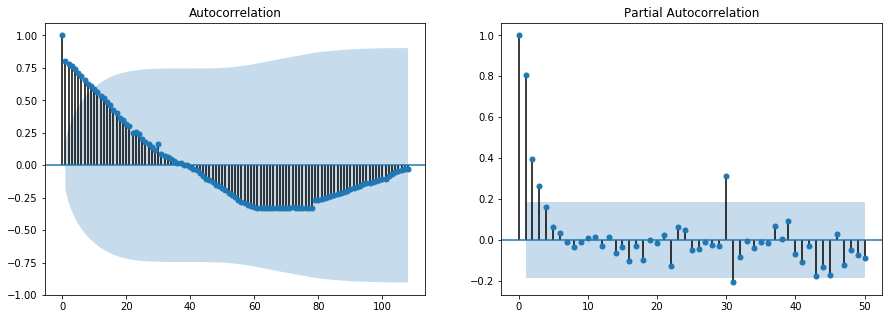

In [8]:
'''Partial and Autocorrelation Plots.'''
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))
plot_acf(df_avg_size['Average Tx Size'], ax = ax1)
plot_pacf(df_avg_size['Average Tx Size'], lags = 50, ax = ax2)
plt.show()

                              ARMA Model Results                              
Dep. Variable:        Average Tx Size   No. Observations:                  109
Model:                     ARMA(1, 1)   Log Likelihood                -663.698
Method:                       css-mle   S.D. of innovations            105.556
Date:                Thu, 24 May 2018   AIC                           1335.395
Time:                        08:55:54   BIC                           1346.160
Sample:                    01-31-2009   HQIC                          1339.761
                         - 01-31-2018                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   440.6005    201.170      2.190      0.031      46.314     834.886
ar.L1.Average Tx Size     0.9909      0.011     89.116      0.000       0.969       1.013
ma.L1.Av

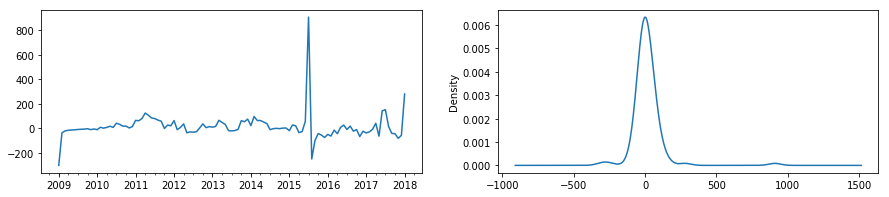

In [209]:
'''Fitting model.'''
#ARMA(1,1) was used whereby the value of x at time t is a linear function of the value of x at time t–1 x's error at time t-1.
model = ARIMA(df_avg_size['Average Tx Size'], order=(1,0,1)) 
model_fit = model.fit(disp=0)
print(model_fit.summary())
#plot residual errors to check assumptions of stationarity and normality. 
f, (ax1, ax2) = plt.subplots(1,2, figsize = (15,3))
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(ax = ax1)
residuals.plot(ax = ax2, kind='kde')
ax1.legend().set_visible(False)
ax2.legend().set_visible(False)

3-step forecast:  [ 680.33875814  678.14875894  675.97876528]
3-step forecast Confidence Intervals: 
 [[ 473.45209559  887.22542069]
 [ 462.10676688  894.190751  ]
 [ 451.31062204  900.64690852]]


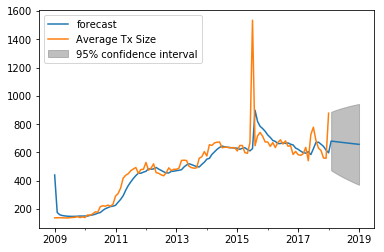

In [210]:
'''Predicting next 3 values.'''
forecasts = model_fit.forecast(steps = 3)
print("3-step forecast: ", forecasts[0]) #print the actual forecasts for the next few average transaction size. 
print("3-step forecast Confidence Intervals: \n", forecasts[2]) #print the confidence intervals for the above forecasts.
model_fit.plot_predict('2009', '2019')
plt.show() #plot displays the predictions vs. the observed values fom 2009.

## Average Transaction Count Per Block

In [5]:
%time tx_count = [(block.height, len(block.txes)) for block in chain[0:400000]]

CPU times: user 3.5 s, sys: 420 ms, total: 3.92 s
Wall time: 3.92 s


In [6]:
%time tx_count2 = [(block.height, len(block.txes)) for block in chain[400000:510000]]

CPU times: user 3.97 s, sys: 696 ms, total: 4.67 s
Wall time: 4.67 s


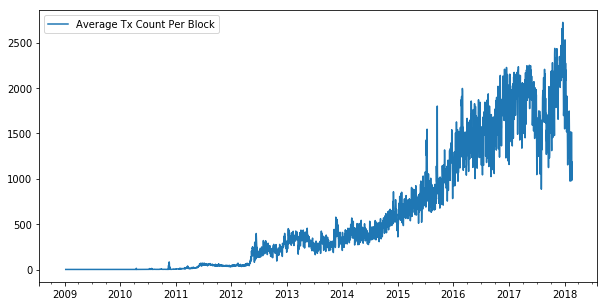

In [7]:
avg_tx_count = tx_count + tx_count2
df_avg_count = pd.DataFrame(avg_tx_count, columns=["Height", "Average Tx Count Per Block"])
df_avg_count = chain.heights_to_dates(df_avg_count)
#Plot the daily average transaction count per block. 
del df_avg_count["Height"]
df_avg_count = df_avg_count.resample("d").mean()
df_avg_count.plot(figsize=(10, 5))

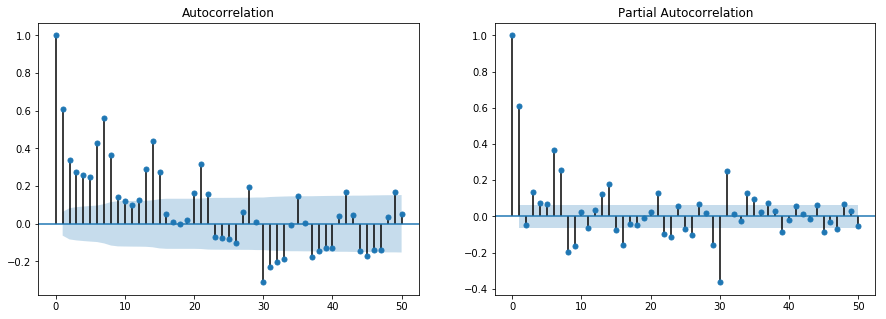

In [55]:
'''Partial and Autocorrelation Plots.'''
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))
plot_acf(df_avg_count['Average Tx Count Per Block'].tail(1000).diff(30).dropna(), lags = 50, ax = ax1) 
plot_pacf(df_avg_count['Average Tx Count Per Block'].tail(1000).diff(30).dropna(), lags = 50, ax = ax2)
plt.show() 

                                  ARMA Model Results                                  
Dep. Variable:     Average Tx Count Per Block   No. Observations:                 1000
Model:                             ARMA(1, 4)   Log Likelihood               -6666.469
Method:                               css-mle   S.D. of innovations            189.655
Date:                        Thu, 31 May 2018   AIC                          13344.938
Time:                                08:01:35   BIC                          13374.384
Sample:                            05-27-2015   HQIC                         13356.129
                                 - 02-19-2018                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
ar.L1.Average Tx Count Per Block     0.9994      0.001   1681.849      0.000       0.998       1.001
m

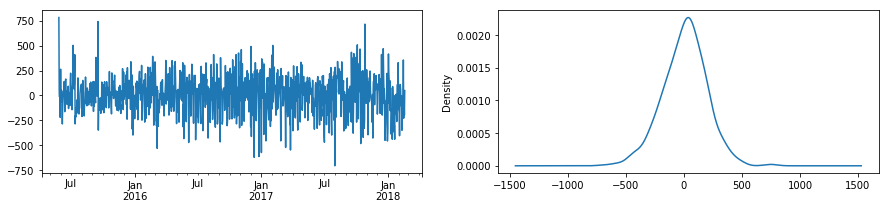

In [74]:
'''Fitting model.'''
#ARMA(1,4) model was used. The current value of x is dependent on the past value at time t-1 and the past 4 error terms. 
model = ARIMA(df_avg_count['Average Tx Count Per Block'].tail(1000).dropna(), order=(1,0,4))
model_fit_count = model.fit(disp=0, trend = 'nc')
print(model_fit_count.summary())
#plot residual errors to check normality and stationarity assumptions.
f, (ax1, ax2) = plt.subplots(1,2, figsize = (15,3))
residuals = pd.DataFrame(model_fit_count.resid)
residuals.plot(ax = ax1)
residuals.plot(ax = ax2, kind='kde')
ax1.legend().set_visible(False)
ax2.legend().set_visible(False)

3-step forecast:  [ 1204.86527122  1216.71632704  1216.02692914]
3-step forecast Confidence Intervals: 
 [[  833.1477311   1576.58281135]
 [  783.84686111  1649.58579297]
 [  770.32621859  1661.7276397 ]]


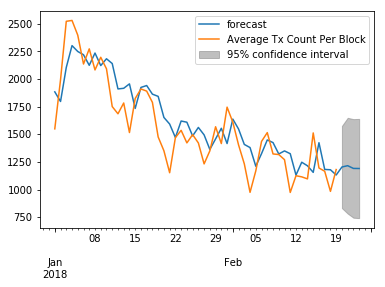

In [75]:
'''Predicting next 3 values.'''
forecasts = model_fit_count.forecast(steps = 3)
print("3-step forecast: ", forecasts[0]) #print predictions. 
print("3-step forecast Confidence Intervals: \n", forecasts[2]) #confidence interval of predictions. 
model_fit_count.plot_predict('2018','2018-2-23')
plt.show() #display the next few predicted values against the observed values from 2018.

## Average Fee per Transaction

In [144]:
%time fees = [sum(block.txes.fee) / len(block) for block in chain[0:400000]]
%time times = [block.time for block in chain[0:400000]]

CPU times: user 1min 40s, sys: 1.5 s, total: 1min 41s
Wall time: 1min 49s
CPU times: user 724 ms, sys: 516 ms, total: 1.24 s
Wall time: 1.28 s


In [145]:
%time fees2 = [sum(block.txes.fee) / len(block) for block in chain[400000:510000]]
%time times2 = [block.time for block in chain[400000:510000]]

CPU times: user 2min 43s, sys: 4.21 s, total: 2min 47s
Wall time: 3min 10s
CPU times: user 196 ms, sys: 144 ms, total: 340 ms
Wall time: 337 ms


Text(0.5,1,'Average Fee per Transaction for Past Year')

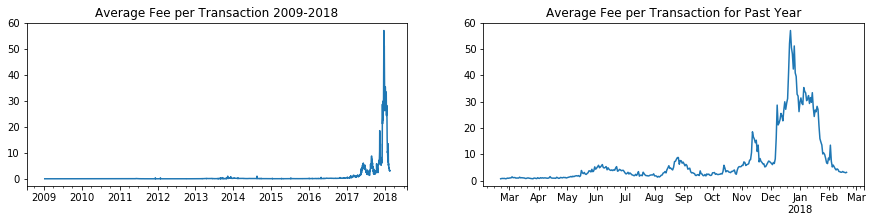

In [146]:
avg_tx_fee = fees + fees2 
dates = times + times2
df_avg_fee = pd.DataFrame({"Fee":avg_tx_fee}, index=dates)
df_avg_fee = converter.satoshi_to_currency_df(df_avg_fee, chain) #convert to USD 
#sample by daily summary 
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,3))
df_avg_fee = df_avg_fee.resample("d").mean()
df_avg_fee.plot(legend = False, ax = ax1)
df_avg_fee.tail(365).plot(legend = False, ax = ax2)
ax1.set_title("Average Fee per Transaction 2009-2018")
ax2.set_title("Average Fee per Transaction for Past Year")

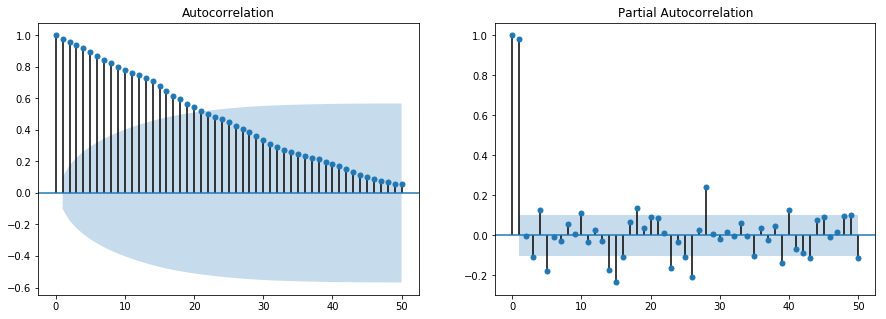

In [84]:
'''Partial and Autocorrelation Plots.'''
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))
plot_acf(df_avg_fee['Fee'].tail(365).dropna(), lags = 50, ax = ax1) #ACF and PACF of differenced data 
plot_pacf(df_avg_fee['Fee'].tail(365).dropna(), lags = 50, ax = ax2)
plt.show() 

                              ARMA Model Results                              
Dep. Variable:                    Fee   No. Observations:                  365
Model:                     ARMA(1, 0)   Log Likelihood                -775.656
Method:                       css-mle   S.D. of innovations              2.016
Date:                Thu, 31 May 2018   AIC                           1555.312
Time:                        09:26:16   BIC                           1563.112
Sample:                    02-20-2017   HQIC                          1558.412
                         - 02-19-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.Fee      0.9848      0.008    125.601      0.000       0.969       1.000
                                    Roots                                    
                  Real          Imaginary           M

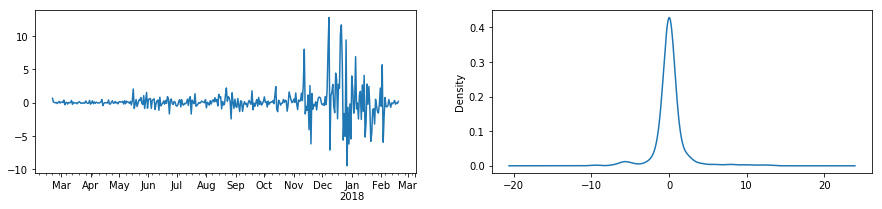

In [85]:
'''Fitting Model'''
model = ARIMA(df_avg_fee['Fee'].tail(365).dropna(), order=(1,0,0)) #ARMA(1,0)
model_fit_fee = model.fit(disp=0, trend = 'nc')
print(model_fit_fee.summary())
#plot residual errors.
f, (ax1, ax2) = plt.subplots(1,2, figsize = (15,3))
residuals = pd.DataFrame(model_fit_fee.resid)
residuals.plot(ax = ax1)
residuals.plot(ax = ax2, kind='kde')
ax1.legend().set_visible(False)
ax2.legend().set_visible(False)

3-step forecast:  [ 21.19268708  20.22972246  19.32419378]
3-step forecast Confidence Intervals: 
 [[  4.07151352e-01   1.10310327e+03]
 [  7.88866117e-02   5.18772022e+03]
 [  2.28019313e-02   1.63768788e+04]]


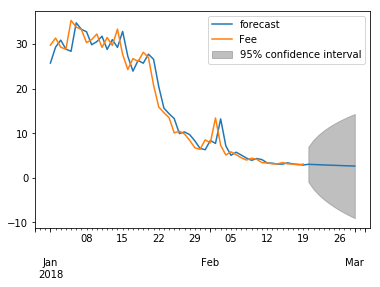

In [89]:
'''Predicting next 3 values.'''
forecasts = model_fit_fee.forecast(steps = 3)
print("3-step forecast: ", np.exp(forecasts[0])) #display predictions.
print("3-step forecast Confidence Intervals: \n", np.exp(forecasts[2])) #display confidence intervals of predictions.
model_fit_fee.plot_predict('2018', '2018-03-01')
plt.show() #plot predicted values from 2018.

## Miner's Revenue per Block from 2017

In [472]:
%time miner_revenue = [block.revenue for block in chain.range(start = "2017-01-01", end = "2018-09-18")]
times = [block.time for block in chain.range(start = "2017-01-01", end = "2018-09-18")]

CPU times: user 180 ms, sys: 4 ms, total: 184 ms
Wall time: 192 ms


Text(0.5,1,"Total Miner's Revenue from 2018")

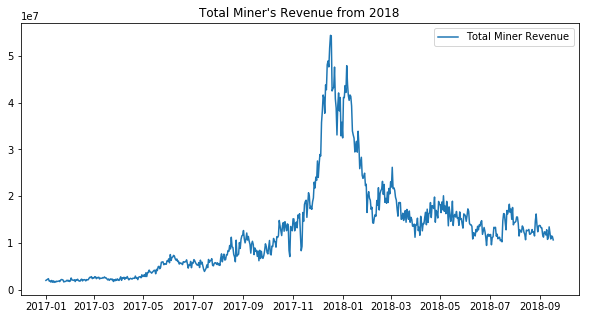

In [490]:
df_miner_rev = pd.DataFrame({"Miner Revenue":miner_revenue}, index=times)
#resample by daily summary.
df_miner_rev = df_miner_rev.resample("d").sum()
df_miner_rev = converter.satoshi_to_currency_df(df_miner_rev, chain.range(start = "2017-01-01", end = "2018-09-18"))
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df_miner_rev)
ax.legend(["Total Miner Revenue"])
ax.set_title("Total Miner's Revenue from 2018")

In [474]:
result = adfuller(df_miner_rev['Miner Revenue'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -8.310896
p-value: 0.000000


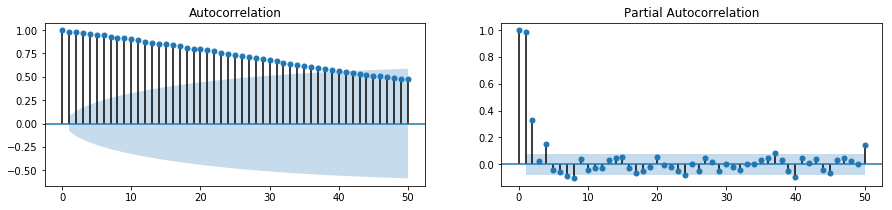

In [475]:
'''Partial and Autocorrelation Plots.'''
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,3))
plot_acf(df_miner_rev['Miner Revenue'], lags = 50, ax = ax1)
plot_pacf(df_miner_rev['Miner Revenue'], lags = 50, ax = ax2)
plt.show() 

                             ARIMA Model Results                              
Dep. Variable:        D.Miner Revenue   No. Observations:                  364
Model:                 ARIMA(1, 1, 3)   Log Likelihood                 235.821
Method:                       css-mle   S.D. of innovations              0.127
Date:                Thu, 31 May 2018   AIC                           -459.643
Time:                        09:28:28   BIC                           -436.260
Sample:                    01-02-2017   HQIC                          -450.349
                         - 12-31-2017                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.0079      0.003      2.600      0.010       0.002       0.014
ar.L1.D.Miner Revenue    -0.7845      0.108     -7.283      0.000      -0.996      -0.573
ma.L1.D.

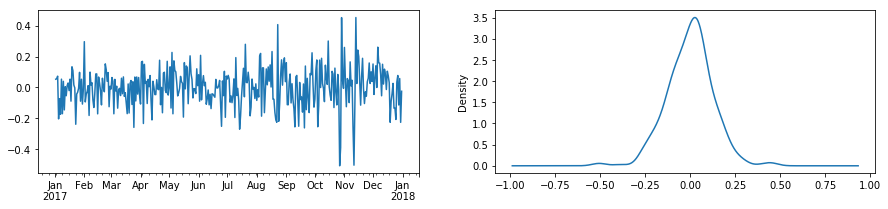

In [93]:
'''Fitting model.'''
df_miner_rev_logged = np.log(df_miner_rev)
model_miner_rev = ARIMA(df_miner_rev_logged['Miner Revenue'], order=(1,1,3)) #ARIMA(1,1,3)
model_fit_miner_rev = model_miner_rev.fit(disp=0)
print(model_fit_miner_rev.summary())
#plot residual errors.
f, (ax1, ax2) = plt.subplots(1,2, figsize = (15,3))
residuals = pd.DataFrame(model_fit_miner_rev.resid)
residuals.plot(ax = ax1)
residuals.plot(ax = ax2, kind='kde')
ax1.legend().set_visible(False)
ax2.legend().set_visible(False)

3-step forecast:  [ 36037598.41978846  38282534.99780115  37031208.34413851]
3-step forecast Confidence Intervals: 
 [[ 28123061.22559499  46179485.56339864]
 [ 28760790.82751696  50956612.93345589]
 [ 26951152.53626977  50881326.48804312]]


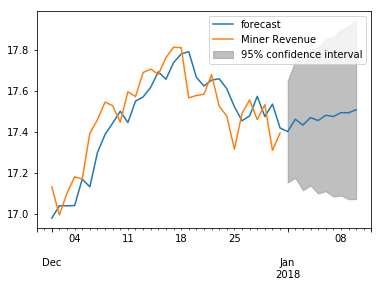

In [100]:
'''Predicting next 3 values.'''
forecasts = model_fit_miner_rev.forecast(steps = 3)
print("3-step forecast: ", np.exp(forecasts[0])) #predictions 
print("3-step forecast Confidence Intervals: \n", np.exp(forecasts[2])) #confidence interval of predictions 
model_fit_miner_rev.plot_predict('2017-12', '2018-1-10')
plt.show() #plot predictions against observed values from the last month. 

## Unspent Transaction Outputs

In [130]:
%time unspent1 = [block.outputs.unspent.all for block in chain[0:400000]]
%time unspent2 = [block.outputs.unspent.all for block in chain[400000:510000]]

CPU times: user 17.8 s, sys: 0 ns, total: 17.8 s
Wall time: 17.8 s
CPU times: user 29.5 s, sys: 832 ms, total: 30.4 s
Wall time: 30.4 s


In [131]:
%time times = [block.time for block in chain[0:400000]]
%time times2 = [block.time for block in chain[400000:510000]]

CPU times: user 928 ms, sys: 444 ms, total: 1.37 s
Wall time: 1.37 s
CPU times: user 280 ms, sys: 108 ms, total: 388 ms
Wall time: 387 ms


In [132]:
'''Getting the value of these outputs.'''
for txes in unspent1: 
    for i in range(0, len(txes)):
        txes[i] = txes[i].value 
for txes in unspent2:
    for i in range(0, len(txes)):
        txes[i] = txes[i].value

In [133]:
#takes awhile to run. 
unspent = unspent1 + unspent2
times = times + times2
df_unspent = pd.DataFrame({"Value of Unspent Transaction Outputs":unspent[0]}, index=times)
df_unspent = converter.satoshi_to_currency_df(df_unspent, chain) #convert to USD 

Text(0.5,1,'Total Value of Unspent Transaction Outputs from Past Year')

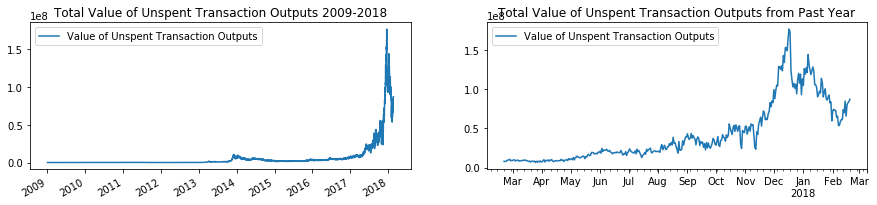

In [134]:
df_unspent = df_unspent.resample("d").sum().dropna()
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,3))
df_unspent.plot(ax = ax1)
df_unspent.tail(365).plot(ax = ax2) #plot the last year
ax1.set_title("Total Value of Unspent Transaction Outputs 2009-2018")
ax2.set_title("Total Value of Unspent Transaction Outputs from Past Year")

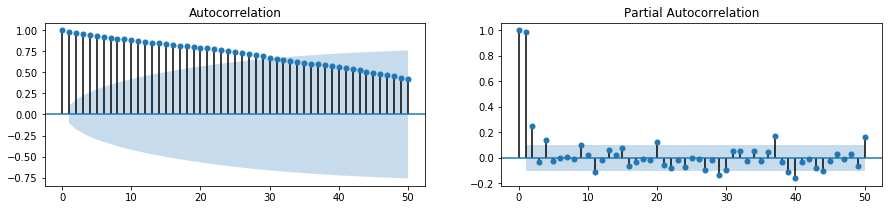

In [110]:
'''Partial and Autocorrelation Plots.'''
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,3))
plot_acf(df_unspent['Value of Unspent Transaction Outputs'].tail(365).dropna(), lags = 50, ax = ax1)
plot_pacf(df_unspent['Value of Unspent Transaction Outputs'].tail(365).dropna(), lags = 50, ax = ax2)
plt.show() 

                                       ARIMA Model Results                                        
Dep. Variable:     D.Value of Unspent Transaction Outputs   No. Observations:                  364
Model:                                     ARIMA(1, 1, 1)   Log Likelihood               -6249.005
Method:                                           css-mle   S.D. of innovations        6910233.433
Date:                                    Thu, 31 May 2018   AIC                          12504.010
Time:                                            09:34:27   BIC                          12515.702
Sample:                                        02-21-2017   HQIC                         12508.657
                                             - 02-19-2018                                         
                                                   coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

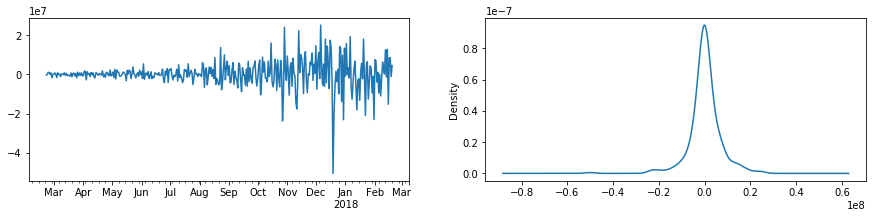

In [111]:
'''Fitting model.'''
model_unspent = ARIMA(df_unspent['Value of Unspent Transaction Outputs'].tail(365), order=(1,1,1)) #ARIMA(1,1,3)
model_fit_unspent = model_unspent.fit(disp=0, trend = 'nc')
print(model_fit_unspent.summary())
#plot residual errors.
f, (ax1, ax2) = plt.subplots(1,2, figsize = (15,3))
residuals = pd.DataFrame(model_fit_unspent.resid)
residuals.plot(ax = ax1)
residuals.plot(ax = ax2, kind='kde')
ax1.legend().set_visible(False)
ax2.legend().set_visible(False)

3-step forecast:  [ 87412179.51920022  87145663.28550954  87339559.91056563]
3-step forecast Confidence Intervals: 
 [[  7.38683709e+07   1.00955988e+08]
 [  6.97415738e+07   1.04549753e+08]
 [  6.57165795e+07   1.08962540e+08]]


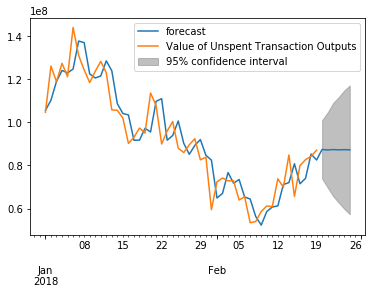

In [115]:
'''Predicting next 3 values.'''
forecasts = model_fit_unspent.forecast(steps = 3)
print("3-step forecast: ", forecasts[0]) #predictions. 
print("3-step forecast Confidence Intervals: \n", forecasts[2]) #confidence interval of predictions. 
model_fit_unspent.plot_predict('2018', '2018-02-25')
plt.show() #display predictions against observed values from 2018. 

## Measuring Different Types of Address Use

In [44]:
#For each block, return a set of the net change in the utxo pool after this block split up by address type
%time net_coins_per_block = chain.map_blocks(lambda block: block.net_address_type_value(), '2009', '2018-09-30')

CPU times: user 9.95 s, sys: 1.81 s, total: 11.8 s
Wall time: 4min 43s


(0, 13313558.289755534)

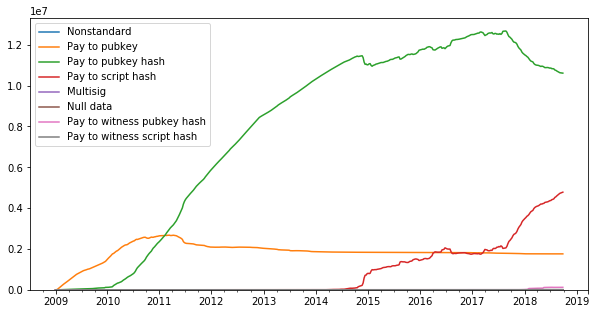

In [45]:
df = pd.DataFrame(net_coins_per_block).fillna(0).cumsum()/1e8
df = chain.heights_to_dates(df)
df = df.rename(columns={t:str(t) for t in df.columns})
ax = df.resample("W").mean().plot(figsize = (10,5)) #resample to take the weekly average. 
ax.set_ylim(ymin=0)

In [47]:
%time fees3 = [sum(block.txes.fee) / len(block) for block in chain.range(start = "2017-01-01", end = "2018-09-18")]
%time times3 = [block.time for block in chain.range(start = "2017-01-01", end = "2018-09-18")]

CPU times: user 2min 17s, sys: 2.81 s, total: 2min 19s
Wall time: 2min 47s
CPU times: user 200 ms, sys: 104 ms, total: 304 ms
Wall time: 303 ms


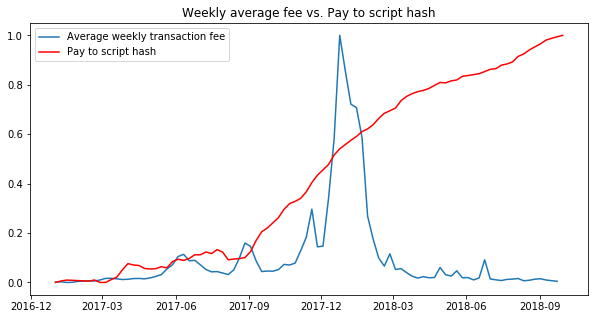

In [51]:
'''Relationship between pay to script hash and average transaction fees.'''
df_avg_fee = pd.DataFrame({"Fee":fees3}, index=times3)
df_avg_fee = converter.satoshi_to_currency_df(df_avg_fee, chain.range(start = "2017-01-01", end = "2018-09-18"))#convert to USD
df_avg_fee_weekly = df_avg_fee.resample("W").mean()
df_weekly = df.resample("W").mean()
#df_avg_fee_weekly.drop(df_avg_fee_weekly.tail(8).index,inplace=True) #drop last 8 rows 

#apply min max normalisation on the dataframes 
df_avg_fee_weekly = (df_avg_fee_weekly-df_avg_fee_weekly.min())/(df_avg_fee_weekly.max()-df_avg_fee_weekly.min())
df_weekly = (df_weekly-df_weekly.min())/(df_weekly.max()-df_weekly.min())
plt.figure(figsize = (10,5))
plt.plot(df_avg_fee_weekly, label = "Average weekly transaction fee")
plt.plot(df_weekly["Pay to script hash"].tail(100), color = "red")
plt.title("Weekly average fee vs. Pay to script hash")
plt.legend()
plt.show()

## Exchange Wallet Activity vs. Price

In [9]:
#import blocksci.cluster_python
from datetime import datetime
import calendar
cm = blocksci.cluster.ClusterManager("/home/ubuntu/bitcoin/clusters", chain)

In [314]:
datelist = pd.date_range('2009-01-03', '2018-05-31').tolist()
daily_price = [] 
for date in datelist: 
    daily_price.append(converter.btc_to_currency(1,date))
btc_price_df = pd.DataFrame({'Price': daily_price}, index = datelist)

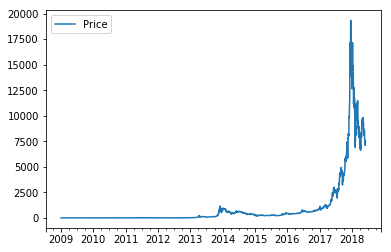

In [315]:
btc_price_df.plot() #price of bitcoin in USD 

In [7]:
def get_wallet_balance(address_string): 
    '''Get wallet of bitcoin exchange wallet.'''
    address = chain.address_from_string(address_string)
    cluster = cm.cluster_with_address(address)
    balance = [cluster.balance(block.height) for block in chain.range(start = "2017-01-01", end = "2018-09-30")]
    return balance

In [11]:
%time bitfinex_bal = get_wallet_balance("3D2oetdNuZUqQHPJmcMDDHYoqkyNVsFk9r") #bitfinex exchange wallet. 

CPU times: user 9min 1s, sys: 560 ms, total: 9min 1s
Wall time: 9min 2s


In [10]:
%time binance_bal = get_wallet_balance("16ftSEQ4ctQFDtVZiUBusQUjRrGhM3JYwe") #binance exchange wallet

CPU times: user 29.6 s, sys: 492 ms, total: 30.1 s
Wall time: 30.2 s


In [12]:
%time bittrex_bal = get_wallet_balance("16rCmCmbuWDhPjWTrpQGaU3EPdZF7MTdUk") #bittrex exchange wallet

CPU times: user 12min 22s, sys: 4 ms, total: 12min 22s
Wall time: 12min 23s


In [13]:
%time bitstamp_bal = get_wallet_balance("3Nxwenay9Z8Lc9JBiywExpnEFiLp6Afp8v") #bitstamp exchange wallet 

CPU times: user 25 s, sys: 44 ms, total: 25 s
Wall time: 25.5 s


In [14]:
%time huobi_bal = get_wallet_balance("3Cbq7aT1tY8kMxWLbitaG7yT6bPbKChq64") #huobi exchange wallet 

CPU times: user 21.4 s, sys: 4 ms, total: 21.4 s
Wall time: 21.7 s


In [15]:
%time dates = [block.time for block in chain.range(start = "2017-01-01", end = "2018-09-30")]
prices = []
for date in dates: 
    prices.append(converter.btc_to_currency(1,date))

CPU times: user 208 ms, sys: 128 ms, total: 336 ms
Wall time: 453 ms


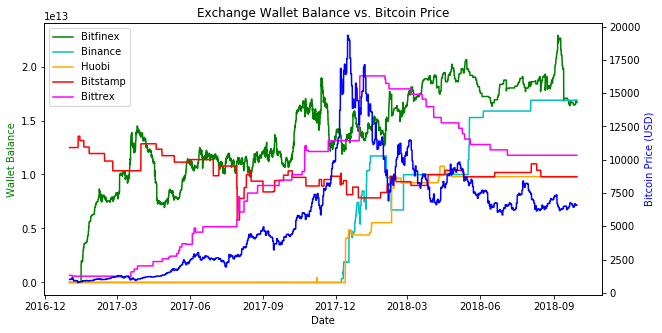

In [16]:
'''Plot bitcoin price against balances of large exchange wallets.'''
balance_df = pd.DataFrame({"Bitfinex Bal": bitfinex_bal, "Binance Bal": binance_bal,
                          "Bitstamp Bal": bitstamp_bal, "Bittrex Bal": bittrex_bal, "Huoubi Bal": huobi_bal}, index = dates)
#balance_df = converter.satoshi_to_currency_df(balance_df, chain.range('2017')) #convert balance to USD 
balance_df['Price'] = prices

fig, ax1 = plt.subplots(figsize = (10,5)) 
ax2 = ax1.twinx()

#plot exchange wallet balances 
ax1.plot(dates, balance_df['Bitfinex Bal'], 'g-', label = 'Bitfinex')
ax1.plot(dates, balance_df['Binance Bal'], 'c-', label = 'Binance')
ax1.plot(dates, balance_df['Huoubi Bal'], 'orange', label = 'Huobi')
ax1.plot(dates, balance_df['Bitstamp Bal'], 'r-', label = 'Bitstamp')
ax1.plot(dates, balance_df['Bittrex Bal'], 'magenta', label = 'Bittrex')

#plot bitcoin price 
ax2.plot(dates, balance_df['Price'], 'b-')

ax1.set_xlabel('Date')
ax1.set_ylabel('Wallet Balance', color = 'g')
ax1.set_title('Exchange Wallet Balance vs. Bitcoin Price')
ax1.legend()
ax2.set_ylabel('Bitcoin Price (USD)', color = 'b')
plt.show()

## Cross Correlation of Exchange Wallets and Price

In [17]:
#Aggregating wallets into 1 wallet
bitfinex_bal = np.array(bitfinex_bal)
binance_bal = np.array(binance_bal)
bitstamp_bal = np.array(bitstamp_bal)
huobi_bal = np.array(huobi_bal)
aggregate_wallet_bal = bitfinex_bal + binance_bal + bitstamp_bal + huobi_bal + bittrex_bal

In [18]:
def cross_correlate(wallet, prices, exchange, title = 'Exchange Wallets Cross Correlation'): 
    corr = signal.correlate(wallet, prices, mode = 'full')
    plt.plot(corr, label = exchange) 
    plt.title(title)
    plt.legend()

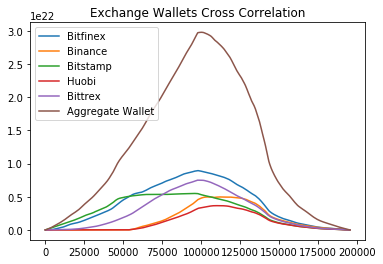

In [19]:
cross_correlate(bitfinex_bal, prices, 'Bitfinex')
cross_correlate(binance_bal, prices, 'Binance')
cross_correlate(bitstamp_bal, prices, 'Bitstamp')
cross_correlate(huobi_bal, prices, 'Huobi')
cross_correlate(bittrex_bal, prices, 'Bittrex')
cross_correlate(aggregate_wallet_bal, prices, 'Aggregate Wallet')

## Identifying Spam Transactions

In [345]:
%time outputs = [(block.time, block.output_value) for block in chain.range("2018")]

CPU times: user 1.44 s, sys: 48 ms, total: 1.49 s
Wall time: 1.49 s


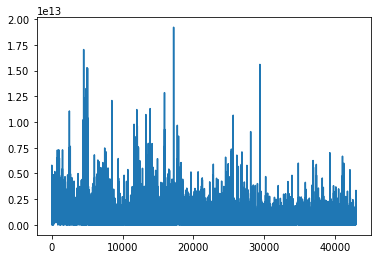

In [344]:
plt.plot(outputs)

In [161]:
%time all_fees = [(block.time, block.txes.fee) for block in chain.range('2017')]

TypeError: unsupported operand type(s) for /: 'list' and 'int'

## Measuring Bitcoin Velocity (still WIP)

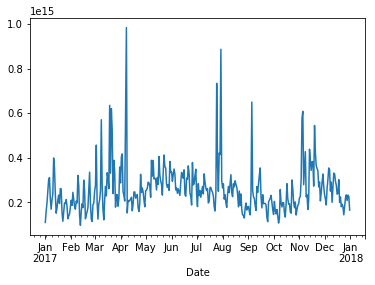

In [160]:
df_outputs = pd.DataFrame(outputs, columns=['Date', 'Output Value', 'Input Value'])
df_outputs = df_outputs.set_index(['Date'])
df_outputs = df_outputs.resample("D", how = 'sum')
df_outputs['Output Value'].plot()

## Comparing Prices of Altcoins

In [23]:
import requests
POLONIEX_OHLCV_BASEURL = 'https://poloniex.com/public?command=returnChartData&currencyPair='

def get_ohlcv_poloniex(pair='BTC_ETH', start=1435699200, end=9999999999, period=900):
    query = POLONIEX_OHLCV_BASEURL + pair + '&start=' + str(start) + '&end=' + str(end) + '&period=' + str(period)
    resp = requests.get(query)
    if resp.status_code != 200:
        raise requests.ApiError('GET /tasks/ {}'.format(resp.status_code))
    return pd.DataFrame(resp.json())

In [24]:
eth = get_ohlcv_poloniex(pair='USDT_ETH', start=1483228800, end=9999999999, period=900)
xmr = get_ohlcv_poloniex(pair='USDT_XMR', start=1483228800, end=9999999999, period=900)
xrp = get_ohlcv_poloniex(pair='USDT_XRP', start=1483228800, end=9999999999, period=900)
ltc = get_ohlcv_poloniex(pair='USDT_LTC', start=1483228800, end=9999999999, period=900)

In [25]:
eth['date'] = pd.to_datetime(eth['date'], unit = 's')
xmr['date'] = pd.to_datetime(xmr['date'], unit = 's')
xrp['date'] = pd.to_datetime(xrp['date'], unit = 's')
ltc['date'] = pd.to_datetime(ltc['date'], unit = 's')

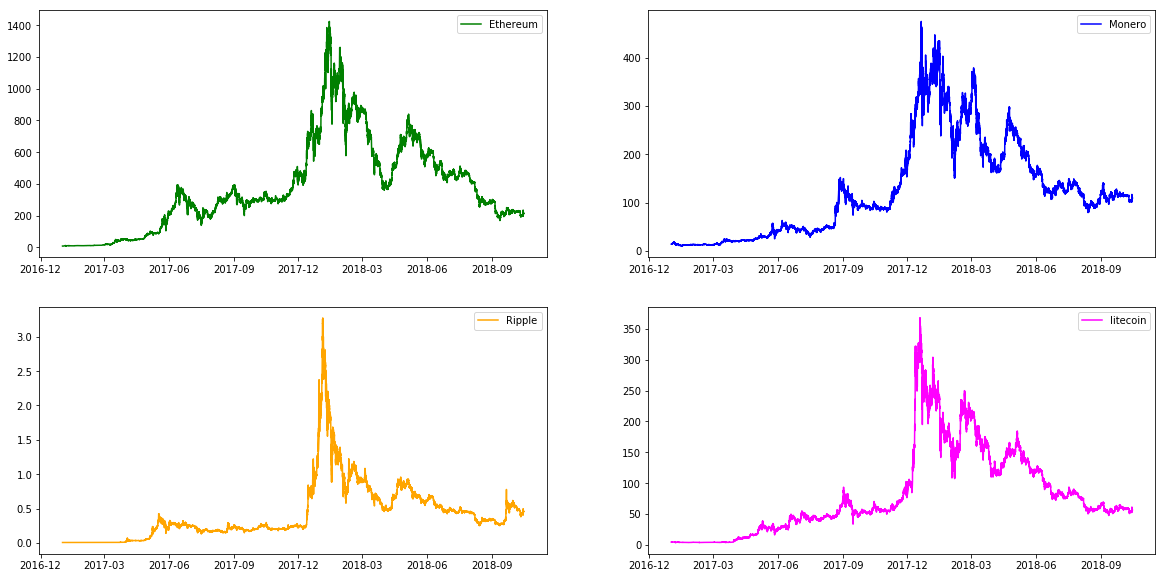

In [26]:
fig, ax = plt.subplots(2, 2, figsize = (20,10)) 
ax[0,0].plot(eth['date'], eth['close'], "green", label = "Ethereum")
ax[0,1].plot(xmr['date'], xmr['close'], "blue", label = "Monero")
ax[1,0].plot(xrp['date'], xrp['close'], "orange", label = "Ripple")
ax[1,1].plot(ltc['date'], ltc['close'], "magenta", label = "litecoin")

for i, ax in enumerate(fig.axes): 
    ax.legend() 

In [20]:
balance_df = balance_df.drop("Price", 1) #delete price column 

## Cross Correlation between Altcoins and Exchange Balance

In [39]:
def edit_df(altcoin): 
    df = pd.DataFrame({"close": altcoin["close"].values}, index = altcoin["date"])
    df = df.resample("D", how = "mean")
    df = df.loc['2017-01-01':'2018-09-29']
    return df

In [40]:
eth_df = edit_df(eth)
xmr_df = edit_df(xmr)
xrp_df = edit_df(xrp)
ltc_df = edit_df(ltc)
balance_df = balance_df.resample("D", how = "mean") #resampling to daily price 
balance_df["Agg Wallet Bal"] = balance_df.sum(axis = 1)

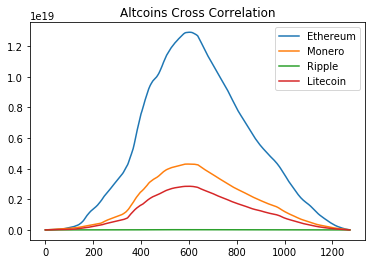

In [28]:
#cross correlation for altcoins and aggregate exchange balance 
cross_correlate(eth_df['close'], balance_df["Agg Wallet Bal"], "Ethereum")
cross_correlate(xmr_df['close'], balance_df["Agg Wallet Bal"], "Monero")
cross_correlate(xrp_df['close'], balance_df["Agg Wallet Bal"], "Ripple")
cross_correlate(ltc_df['close'], balance_df["Agg Wallet Bal"], "Litecoin", title = "Altcoins Cross Correlation")

In [49]:
df = df.resample("D", how = "mean")
df = df.loc['2017-01-01':'2018-09-30']
df_avg_fee =  df_avg_fee.resample("D", how = "mean")
df_avg_fee = df_avg_fee.loc['2017-01-01':'2018-09-30']

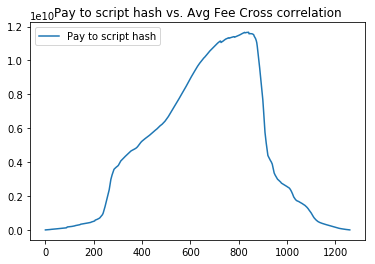

In [50]:
cross_correlate(df["Pay to script hash"], df_avg_fee["Fee"], "Pay to script hash", title = "Pay to script hash vs. Avg Fee Cross correlation")

## Examining lag between Altcoins and Exchange Balance

In [41]:
def search_lag(result): 
    '''Finds the optimal lag.'''
    optimal_lag = -1
    f_test = -1.0
    for key in result.keys(): #loop through the lags 
        curr_f_test = result[key][0]['params_ftest'][0]
        if curr_f_test > f_test: #obtain highest f-test value 
            f_test = curr_f_test
            optimal_lag = key
    return optimal_lag

In [42]:
def reshape_to_2D(x, y):
    '''Takes two arrays and converts to 2D array with shape (-1,2).'''
    data =  np.array([np.array(x.values), np.array(y.values)])
    data = np.reshape(data, (2,-1))
    data = np.transpose(data)
    return data

In [43]:
#Null hypothesis: time series in the second column, x2, does NOT Granger cause the time series in the first column, x1. 
#First param: data for testing whether the time series in the second column Granger causes the time series in the first column
eth_data = reshape_to_2D(eth_df["close"], balance_df["Agg Wallet Bal"])
eth_result = grangercausalitytests(eth_data, maxlag = 20, verbose = False)
eth_lag = search_lag(eth_result) 

xmr_data = reshape_to_2D(xmr_df['close'], balance_df["Agg Wallet Bal"])
xmr_result = grangercausalitytests(xmr_data, maxlag = 20, verbose = False)
xmr_lag = search_lag(xmr_result)

xrp_data = reshape_to_2D(xrp_df['close'], balance_df["Agg Wallet Bal"])
xrp_result = grangercausalitytests(xrp_data, maxlag = 20, verbose = False)
xrp_lag = search_lag(xrp_result)

ltc_data = reshape_to_2D(ltc_df['close'], balance_df["Agg Wallet Bal"])
ltc_result = grangercausalitytests(ltc_data, maxlag = 20, verbose = False)
ltc_lag = search_lag(ltc_result)

print("Ethereum Lag:", eth_lag, "\nMonero Lag:", xmr_lag, "\nRipple Lag:", xrp_lag, "\nLitecoin Lag:", ltc_lag) #shift in days 

Ethereum Lag: 3 
Monero Lag: 9 
Ripple Lag: 1 
Litecoin Lag: 5
